In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import pandas as pd
from aux_func import show_history, r2_keras

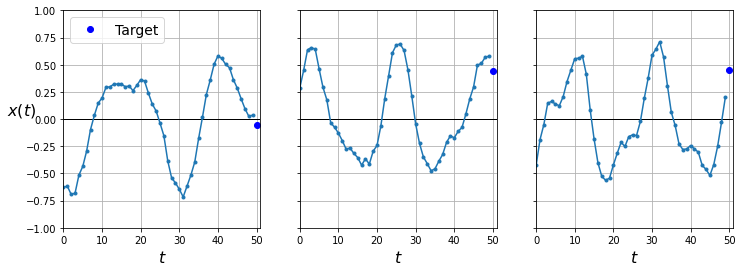

In [ ]:
# Esta función genera una serie temporal seudo aleatoria con cierta periodicidad
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# Generamos train, validation y test
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train_sequence, y_train_sequence = series[:7000, :n_steps], series[:7000, -1]
X_valid_sequence, y_valid_sequence = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test_sequence, y_test_sequence = series[9000:, :n_steps], series[9000:, -1]


# Función para plotear
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid_sequence[col, :, 0], y_valid_sequence[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))

In [ ]:
from tensorflow.keras.layers import LSTM, Dense
from aux_func import r2_keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras.backend as K

input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(5):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)



x = layers.Flatten()(x)
x = layers.Dense(256, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(100, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(1, activation=None)(x)

model = Model(input_tensor, x)
print(model.summary())
  
def custom_loss(y_true, y_pred):
    loss1 = K.square(y_pred - y_true)  
    loss2 = abs(y_true - y_pred)
    loss = loss1 + loss2
    return loss


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=custom_loss ,metrics=['mse', 'mean_absolute_error', r2_keras])
history = model.fit(X_train_sequence,y_train_sequence, epochs=20, batch_size=30, steps_per_epoch=200, shuffle=False,
                    callbacks=[], verbose=1, validation_data=(X_valid_sequence, y_valid_sequence),validation_steps=10)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 50)]              0         
                                                                 
 tf.expand_dims_11 (TFOpLamb  (None, 50, 1)            0         
 da)                                                             
                                                                 
 lstm_66 (LSTM)              (None, 50, 100)           40800     
                                                                 
 lstm_67 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_68 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_69 (LSTM)              (None, 50, 100)           80400     
                                                          

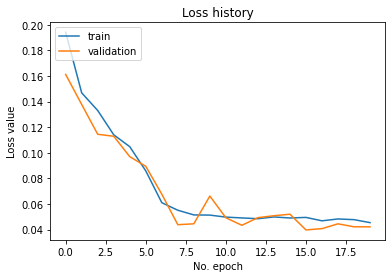

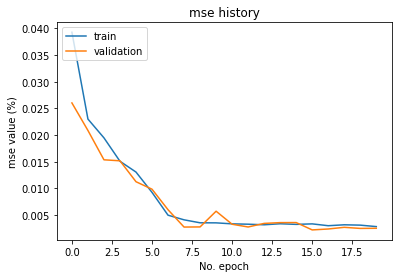

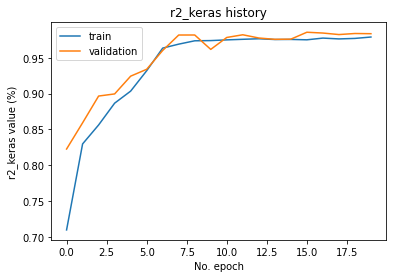

In [ ]:
show_history(history, metrics=['mse', 'r2_keras'])

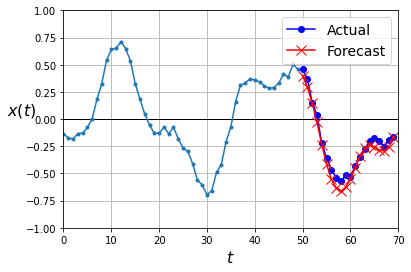

In [ ]:
# Número de pasos en adelante que vamos a predecir
steps_ahead = 20

series = generate_time_series(1, n_steps + steps_ahead)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

# repetimos la predicción varias veces
for step_ahead in range(steps_ahead):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
print(Y_pred)

[[[ 0.39965114]
  [ 0.29314762]
  [ 0.1462124 ]
  [-0.03052038]
  [-0.23395362]
  [-0.41178754]
  [-0.55356604]
  [-0.63690484]
  [-0.6617725 ]
  [-0.6284559 ]
  [-0.5506194 ]
  [-0.44600973]
  [-0.34165415]
  [-0.26222113]
  [-0.23744847]
  [-0.25970948]
  [-0.28496003]
  [-0.29313076]
  [-0.2570195 ]
  [-0.16551295]]]
